**Objective:** 

In this tutorial we will create a simple gravity problem from scratch using the SimPEG framework. The synthetic example used here is based on the Tli Kwi Cho kimberlite deposit, NWT. We are attempting to use the gravity field measurements to image various kimberlite rock units making up the diamond deposit.

Since both gravity and magnetic surveys are very similar (both potentials), we will use this example to showcase the power of geological constraints. By addind the information from a single borehole, we greatly reduce the none-uniqueness of the inverse problem and better recover density structures at depth.

In [1]:
## Need to be on \pf\dev branch !!!
%pylab inline 
import SimPEG.PF as PF
from SimPEG import *
from SimPEG.Utils import io_utils
import matplotlib
import matplotlib.colors as colors
import scipy as sp
import time as tm
import os
from ipywidgets.widgets import interact, IntSlider
psep = os.path.sep #hide
input_file = ".." + psep + "docs" + psep + "content" + psep + "stories"+ psep + "files" + psep + "SimPEG_Grav_Input.inp" #hide

Populating the interactive namespace from numpy and matplotlib
Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [2]:
# Read in the input file which included all parameters at once (mesh, topo, model, survey, inv param, etc.)
driver = PF.GravityDriver.GravityDriver_Inv(input_file)


In [3]:
# We already have created a mesh, model and survey for this example.
# All the elements are stored in the driver, and can be accessed like this:
mesh = driver.mesh
survey = driver.survey

**Setup**

The relation between density and the gravity field is well known, thanks to the classic work of Newton in 1686. Since we generally only measure the vertical component of the field, this relationship can be written as:
$$G(r)_z = \gamma \int_{V}   \rho(r) \left(\frac{z - z_0}{{|\vec r - \vec r_0|}^3}\right) \; dV $$
where $\rho$ is the anomalous density and $\gamma$ is the Newton's gravitational constant.
Once again, this integral can be evaluated analytically for simple prisms, giving rise to a linear system of equations relating a discrete Earth to the observed data:|
$$ \mathbf{d}_z =  \mathbf{F} \; \boldsymbol{\rho} $$

In [4]:
# We did not include a topography file in this example as the information
# about inactive cells is already captured in our starting model.
# Line 6 of the input file specifies a VALUE to be used as inactive flag.

# Get the active cells
actv = driver.activeCells
nC = len(actv) # Number of active cells
ndv = -100

# Create active map to return to full space after the inversion 
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)

# Create a reduced identity map for the inverse problem
idenMap = Maps.IdentityMap(nP=nC)

**Forward system:**

Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, 
#Need to add stuff

the system end up looking like this system:

$$ d^{obs} = \mathbf{F\; \rho}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [5]:
# Now that we have a model and a survey we can build the linear system ...
# Create the forward model operator (the argument forwardOnly=False store the forward matrix to memory)
prob = PF.Gravity.GravityIntegral(mesh, mapping=idenMap, actInd=actv, forwardOnly=False, rtype = 'z')

# Pair the survey and problem
survey.pair(prob)

Begin calculation of forward operator: z
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



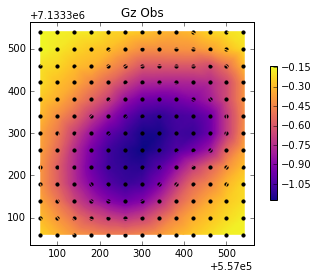

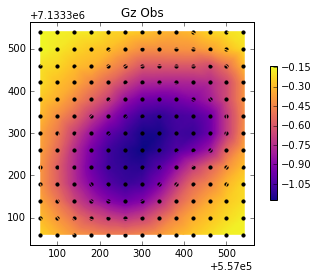

In [6]:
# Fist time that we ask for predicted data,
# the dense matrix T is calculated.
# This is generally the bottleneck of the integral formulation in terms of cost
d = prob.fields(driver.m0)

# Add noise to the data and assign uncertainties
data = d + randn(len(d))*0.01 # We add some random Gaussian noise (1nT)
wd = np.ones(len(data))*np.sqrt(0.01) # Assign flat uncertainties

survey.dobs = data
survey.std = wd

# [OPTIONAL] You can write the observations to UBC format here
#PF.Magnetics.writeUBCobs('MAG_Synthetic_data.obs',survey,data)
PF.Gravity.plot_obs_2D(survey.srcField.rxList[0].locs,d=data)


**Inverse problem**

We have generated synthetic data, we now what to see if we can solve the inverse. Using the usual formulation, we seek a model that can reproduce the data, let’s say a least-squares measure of the form:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2
\end{equation}

The inverse problem is hard because we don’t have great data coverage, and the Earth is big, and there is usually noise in the data. So we need to add something to regularize it.
The simplest way to do it is to penalize solutions that won’t make sense geologically, for example to assume that the model is small.
The usual smooth inversion function use an l2-norm measure:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 \\
\phi_m = \beta \Big [ {\| \mathbf{W}_s \;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}

The full objective function to be minimized can be written as:
\begin{equation}
\phi(m) =  \phi_d + \beta \phi_m\;,
\end{equation}
which will yield our usual *small* and *smooth* models. 

We propose a fancier regularization function that can allow to recover *sparse* and *blocky* solutions.
Starting with the well known Ekblom norm:
\begin{equation}
\phi_m =  \sum_{i=1}^{nc} {(x_i^2 + \epsilon^2)}^{p/2} \;,
\end{equation}
where $x_i$ denotes some function of the model parameter, and $\epsilon$ is a small value to avoid singularity as $m\rightarrow0$.
For p=2, we get the usual least-squares measure and we recover the regularization presented above. For $p \leq 1$, the function becomes non-linear which requires some tweaking.

We can linearize the function by updating the penality function iteratively, commonly known as an Iterative Re-weighted Least-Squares (IRLS) method:
\begin{equation} 
\phi_m^{(k)} =  \frac{1}{2}\sum_{i=1}^{nc} r_i \; x_i^2
\end{equation}
where we added the superscript $\square^{(k)}$ to denote the IRLS iterations. The weights $r(x)$ are computed from model values obtained at a previous iteration such that:
\begin{equation}
	{r}_i  ={\Big( {({x_i}^{(k-1)})}^{2} + \epsilon^2 \Big)}^{p/2 - 1} \;,
\end{equation}
where ${r}(x) \in \mathbb{R}^{nc}$.

In matrix form, our objective function simply becomes:
\begin{equation}
\phi(m) =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 + \beta \Big [ {\| \mathbf{W}_s \;\mathbf{R}_s\;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i\; \mathbf{R}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}
where the IRLS weights $\mathbf{R}_s$ and $\mathbf{R}_i$ are diagonal matrices defined as:
\begin{equation}
\begin{split}
	{R}_{s_{jj}}  &=  \sqrt{\eta_p}{\Big[ {({m_j}^{(k-1)})}^{2} + \epsilon_p^2 \Big]}^{(p/2 - 1)/2} \\
	{R}_{i_{jj}}  &=  \sqrt{\eta_q}{\Big[ {\left ({{(G_i\;m^{(k-1)})}_j }\right)}^{2} + \epsilon_q^2 \Big]}^{(q/2 - 1)/2} \\
\eta_p &=  {\epsilon_p}^{(1-p/2)} \\
\eta_q &=   {\epsilon_q}^{(1-q/2)}  \;, 
\end{split}
\end{equation}

we added two scaling parameters $\eta_p$ and $\eta_q$ for reasons that we won't dicuss here, but turn out to be important to get stable solves.

In order to initialize the IRLS and get an estimate for the stabilizing parameters $\epsilon_p$ and $\epsilon_q$, we first invert with the smooth $l_2$-norm. 
The whole IRLS process is implemented with a directive added to the inversion workflow (see below).


In [7]:
# It is potential fields, so we will need to push the inverison down
# Create distance weights from our linera forward operator
wr = np.sum(prob.G**2.,axis=0)**0.5
wr = ( wr/np.max(wr) )
    
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr

dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1/wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100 ,lower=driver.bounds[0],upper=driver.bounds[1], maxIterLS = 20, maxIterCG= 10, tolCG = 1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of model
# parameters (run last cell to see the histogram before and after IRLS)
IRLS = Directives.Update_IRLS( norms=driver.lpnorms,  eps=(1e-2,1e-2), f_min_change = 1e-4, minGNiter=3)
update_Jacobi = Directives.Update_lin_PreCond()
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest,update_Jacobi])

m0 = np.ones(idenMap.nP)*1e-4


In [8]:
# Run inversion...
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.86e+04  3.57e+03  0.00e+00  3.57e+03    1.68e+02      0              
   1  1.43e+04  3.36e+03  3.70e-03  3.41e+03    1.66e+02      0              
   2  7.15e+03  3.16e+03  1.41e-02  3.26e+03    1.65e+02      0   Skip BFGS  
   3  3.58e+03  2.82e+03  4.90e-02  3.00e+03    1.64e+02      0   Skip BFGS  
   4  1.79e+03  2.31e+03  1.53e-01  2.59e+03    1.62e+02      0   Skip BFGS  
   5  8.94e+02  1.69e+03  4.05e-01  2.05e+03    1.56e+02      0   Skip BFGS  
   6  4.47e+02  1.11e+03  8.68e-01  1.50e+03    1.34e+02      0   Skip BFGS  
   7  2.23e+02  

<function __main__.slide>

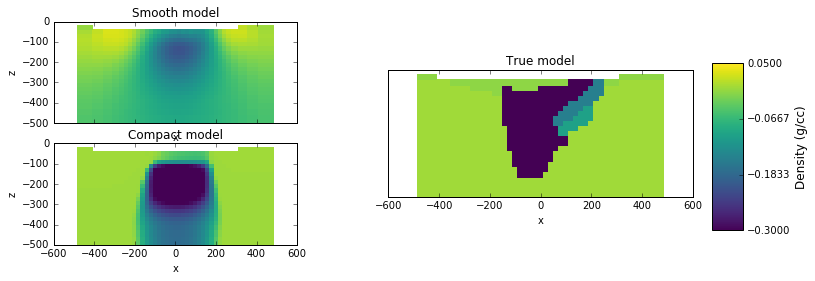

In [9]:
# Get the final model back to full space and plot!!
m_lp = actvMap*mrec
m_lp[m_lp==ndv] = np.nan

# Get the smooth model aslo
m_l2 = actvMap*reg.l2model
m_l2[m_l2==ndv] = np.nan

m_true = actvMap*driver.m0
m_true[m_true==ndv] = np.nan
#[OPTIONAL] Save both models to file
#Mesh.TensorMesh.writeModelUBC(mesh,'SimPEG_MAG_l2l2.sus',m_l2)
#Mesh.TensorMesh.writeModelUBC(mesh,'SimPEG_MAG_lplq.sus',m_lp)

# Plot the recoverd models 
vmin, vmax = -.3, 0.05

mesh = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz],x0="CCN")

def slide(s,normal):
    
    if normal == "Z":
        fig = plt.figure(figsize(10*1.2, 8))
    else:
        fig = plt.figure(figsize(10*1.2, 4))
        
    ax1 = plt.subplot(2,2,3)
    dat = mesh.plotSlice(m_lp, ax = ax1, normal=normal, ind=s, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('Compact model')
    
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
    else:
        xlim(-600, 600)
        ylim(-500, 0.) 
        
    ax2 = plt.subplot(2,2,1)
    dat = mesh.plotSlice(m_l2, ax = ax2, normal=normal, ind=s, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('Smooth model')
    
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
    else:
        xlim(-600, 600)
        ylim(-500, 0.) 
        
    ax2.set_xticklabels([])
        
    ax2 = plt.subplot(1,2,2)
    dat = mesh.plotSlice(m_true, ax = ax2, normal=normal, ind=s, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('True model')
    
    pos =  ax2.get_position()

    ax2.yaxis.set_visible(False)
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.) 
        ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])
    else:
        xlim(-600, 600)
        ylim(-500, 0.) 

    pos =  ax2.get_position()
    cbarax = fig.add_axes([pos.x0 + 0.375 , pos.y0 + 0.05,  pos.width*0.1, pos.height*0.75])  ## the parameters are the specified position you set
    cb = fig.colorbar(dat[0],cax=cbarax, orientation="vertical", ax = ax2, ticks=np.linspace(vmin,vmax, 4))
    cb.set_label("Density (g/cc)",size=12)
    
    #{OPTIONAL} Save the figure to png
    #fig.savefig('PF_Compact.png',dpi = 150)
    
interact(slide, s=(0,34), normal=['Y','Z','X'])